# 사이킷런으로 수행하는 타이타닉 생존자 예측

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
titanic_df = pd.read_csv("./train.csv")
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
print("\n ### 학습 데이터 정보 ### \n")
print(titanic_df.info())


 ### 학습 데이터 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


사이킷런은 Null값을 허용하지 않으므로 Null값을 처리해 주어야합니다.  
Age의 경우에는 평균 나이, 나머지 칼럼은 'N'으로 변경해보겠습니다.  

In [5]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Cabin'].fillna('N', inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True)
print('데이터 세트 Null값 개수 : ', titanic_df.isnull().sum().sum())

데이터 세트 Null값 개수 :  0


현재 남아 있는 문자열 피처는 Sex, Cabin, Embared 입니다.  
이 피처들의 값 분류를 살펴보겠습니다.  

In [8]:
print("Sex 값 분포 :\n ", titanic_df['Sex'].value_counts())
print("Cabin 값 분포 :\n ", titanic_df['Cabin'].value_counts())
print("Embarked 값 분포 :\n ", titanic_df['Embarked'].value_counts())

Sex 값 분포 :
  male      577
female    314
Name: Sex, dtype: int64
Cabin 값 분포 :
  N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64
Embarked 값 분포 :
  S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


Sex, Embarked는 별문제가 없으나, Cabin(선실)의 경우 N이 687건으로 가장 많은것도 특이하지만, 속성값이 제대로 정리가 되지 않은 것 같습니다.  
예를 들어 'C23 C25 C27'과 같이 여러 Cabin이 한꺼번에 표기된 Cabin값이 4건이 됩니다.  
Cabin의 경우 선실 번호 중 선실 등급을 나타내는 첫 번째 알파벳이 중요해 보입니다.  
왜냐하면 이 시절에는 지금보다도 부자와 가난한 사람에 대한 차별이 더 있었던 시절이었기에 일등실에 투숙한 사람들이 삼등실에 투숙한 사람보다 더 살아날 확률이 높았을 것이기 때문입니다.  
Cabin속성의 경우 앞 문자만 추출해보겠습니다.

In [9]:
titanic_df["Cabin"] = titanic_df["Cabin"].str[:1]
print(titanic_df["Cabin"].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


머신러닝 알고리즘을 적용해 예측을 수행하기 전에 데이터를 먼저 탐색해 보겠습니다.  
먼저, 성별이 생존 확률에 어떤 영향을 미쳤는지, 성별에 따른 생존자 수를 비교해보겠습니다.

In [11]:
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

여자는 314명 233명으로 약 74.2%가 생존했지만, 남자의 경우 577명 중 468명이 죽고 109명만 살아남아 약 18.8%가 생존했습니다.

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

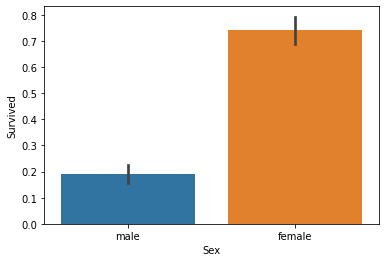

In [12]:
sns.barplot(x='Sex', y='Survived', data=titanic_df)

부자와 가난한 사람 간의 생존 확률은 어떨까요? 부를 측정할 수 있는 속성으로 적당한 것은 객실 등급일 것입니다.  
일등실, 이등실, 마지막으로 삼등실에 따른 생존확률을 그래프로 나타내 보겠습니다.

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

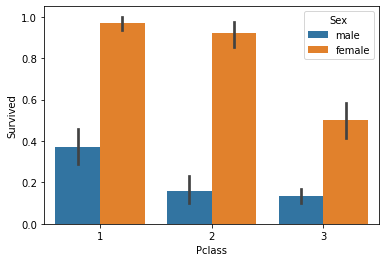

In [14]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)

여성의 경우 일, 이등실에 대한 생존 확률의 차이는 크지 않으나, 삼등실의 경우 생존 확률이 상대적으로 많이 떨어짐을 알 수 있습니다.  
남성의 경우는 일등실의 생존 확률이 이, 삼등실의 생존 확률보다 월등히 높습니다.

이번에는 나이에 따른 생존 확률을 알아보겠습니다.

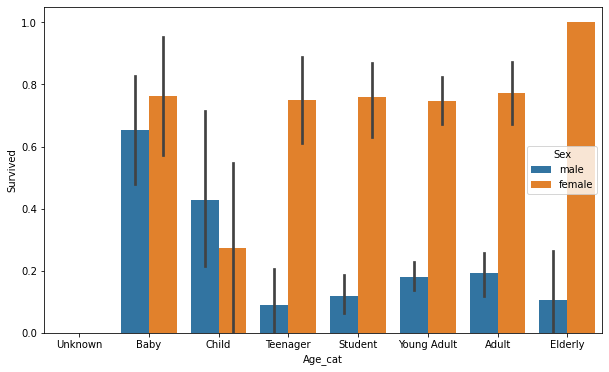

In [16]:
# 입력 age에 따라 구분 값을 반환하는 함수 설정

def get_category(age):
	
	cat = ""

	if age <= -1: cat = "Unknown"
	elif age <= 5: cat = "Baby"
	elif age <= 12: cat = "Child"
	elif age <= 18: cat = "Teenager"
	elif age <= 25: cat = "Student"
	elif age <= 35: cat = "Young Adult"
	elif age <= 60: cat = "Adult"
	else: cat = "Elderly"

	return cat

# 막대 그래프의 크기 figure를 더 크게 설정
plt.figure(figsize=(10, 6))

# X축의 값을 순차적으료 표기하기 위한 설정
group_names = ["Unknown", "Baby", "Child", "Teenager", "Student", "Young Adult", "Adult", "Elderly"]

# lambda 식에 위에서 생성한 get_category()함수를 반환값으로 설정
# get_category(x)는 입력값으로 "Age"칼럼을 받아서 해당하는 cat 반환
titanic_df["Age_cat"] = titanic_df["Age"].apply(lambda x: get_category(x))

sns.barplot(x="Age_cat", y="Survived", hue="Sex", data=titanic_df, order=group_names)
titanic_df.drop("Age_cat", axis=1, inplace=True)

여자 Baby의 경우 비교적 생존 확률이 높았습니다. 아쉽게도 여자 Child의 경우는 다른 연령대에 비해 생존 확률이 낮습니다.  
그리고 여자 Elderly의 경우는 매우 생존 확률이 높았습니다.  
이제까지 분석한 결과 Sex, Age, PClass등이 중요하게 생존을 좌우하는 피처임을 어느정도 확인할 수 있었습니다.

이제 남아있는 문자열 카테고리 피처를 숫자형 카테고리 피처로 변환하겠습니다.  
인코딩은 사이킷런의 LabelEncoder클래스를 이용해 레이블 인코딩을 적용하겠습니다.  

In [17]:
from sklearn import preprocessing

def encode_features(dataDf):
	features = ['Cabin', 'Sex', 'Embarked']
	for feature in features:
		le = preprocessing.LabelEncoder()
		le = le.fit(dataDf[feature])
		dataDf[feature] = le.transform(dataDf[feature])
	return dataDf

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


지금까지 피처를 가공한 내역들을 정리하고 이를 함수로 만들어 쉽게 재사용할 수 있도록 하겠습니다.

In [18]:
# Null처리 함수
def fillna(df):
	df['Age'].fillna(df['Age'].mean(), inplace=True)
	df['Cabin'].fillna('N', inplace=True)
	df['Embarked'].fillna('N', inplace=True)
	df['Fare'].fillna(0, inplace=True)
	return df

# 머신러닝 알고르즘에 불필요한 속성 제거
def drop_features(df):
	df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
	return df

# 레이블 인코딩 수행
def format_feature(df):
	df['Cabin'] = df['Cabin'].str[:1]
	features = ['Cabin', 'Sex', 'Embarked']
	for feature in features:
		le = preprocessing.LabelEncoder()
		le = le.fit(df[feature])
		df[feature] = le.transform(df[feature])
	return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
	df = fillna(df)
	df = drop_features(df)
	df = format_feature(df)
	return df

In [19]:
# 원본 데이터를 재로딩하고, 피처 데이터 세트와 레이블 데이터 세트 추출
titanic_df = pd.read_csv("./train.csv")
y_titanic_df = titanic_df["Survived"]
X_titanic_df = titanic_df.drop("Survived", axis=1)

X_titanic_df = transform_features(X_titanic_df)

In [20]:
# 데이터들을 학습 데이터세트, 테스트 데이터세트로 추출
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

ML 알고리즘인 결정 트리, 랜덤 포레스트, 로지스틱 회귀를 이용해 타이타닉 생존자를 예측해보겠습니다.  
예측 성능 평가는 정확도로 할 것이며 accuracy_score() API를 사용합니다.

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier객체 생성
dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier()
lr_clf = LogisticRegression()

# DecisionTreeClassifier 학습/예측 평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print("DecisionTreeClassifier 정확도 : ", round(accuracy_score(dt_pred, y_test), 4))

# RandomForestClassifier 학습/예측 평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print("RandomForestClassifier 정확도 : ", round(accuracy_score(rf_pred, y_test), 4))

# LogisticRegression 학습/예측 평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print("LogisticRegression 정확도 : ", round(accuracy_score(lr_pred, y_test), 4))

DecisionTreeClassifier 정확도 :  0.7877
RandomForestClassifier 정확도 :  0.8324
LogisticRegression 정확도 :  0.8492


/Users/bang-ahyeon/opt/anaconda3/envs/ds_study/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


아직 최적화 작업을 수행하지 않았고, 데이터 양도 충분하지 않기 때문에 어떤 알고리즘이 성능이 가장 좋다고 평가할 수는 없습니다.

다음으로는 교차 검증으로 결정 트리 모델을 좀 더 평가해보겠습니다.  
앞에서 언급한 교차 검증을 위한 사이킷런 model_selection 패키지의 KFold클래스, cross_val_score(), GridSearchCV 클래스를 모두 사용합니다.
먼저 사이킷런의 KFold 클래스를 이용해 교차 검증을 수행하며, 폴드 개수는 5개로 정합니다.

In [26]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
	# 폴드 세트를 5개인 KFold객체를 생성, 폴드 수만큼 예측결과 저장을 위한 리스트 객체 생성
	kfold = KFold(n_splits=folds)
	scores = []

	# KFold 교차 검증 수행.
	for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
		# X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
		X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
		y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
		# Classifier 학습, 예측, 정확도 계산
		clf.fit(X_train, y_train)
		pred = clf.predict(X_test)
		accuracy = accuracy_score(y_test, pred)
		scores.append(accuracy)
		print("교차 검증 {0} 정확도 : {1:.4f}".format(iter_count, accuracy))
	
	# 5개 fold에서의 평균 정확도 계산
	mean_score = np.mean(scores)
	print("평균 정확도 : {0:.4f}".format(mean_score))

# exec_kfold 호출
exec_kfold(dt_clf, folds=5)

교차 검증 0 정확도 : 0.7430
교차 검증 1 정확도 : 0.7697
교차 검증 2 정확도 : 0.7921
교차 검증 3 정확도 : 0.7697
교차 검증 4 정확도 : 0.8258
평균 정확도 : 0.7801


평균 정확도는 약 78.01% 입니다.  
이번에는 교차 검증을 cross_val_score() API를 이용해 수행합니다.

In [27]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv=5)
for iter_count, accuracy in enumerate(scores):
	print("교차 검증 {0} 정확도 : {1:.4f}".format(iter_count, accuracy))
print("평균 정확도 : {0}".format(np.mean(scores)))

교차 검증 0 정확도 : 0.7486
교차 검증 1 정확도 : 0.7809
교차 검증 2 정확도 : 0.7978
교차 검증 3 정확도 : 0.7921
교차 검증 4 정확도 : 0.8315
평균 정확도 : 0.7901701085933086


cross_val_score()와 방금 전 K 폴드의 평균 정확도가 약간 다른데, 이는 cross_val_score()가 StratifiedKFold를 이용해 폴드 세트를 분할하기 때문입니다.

마지막으로 GridSearchCV를 이용해 DecisionTreeClassfier의 최적 하이퍼 파라미터를 찾고 예측성능을 측정해보겠습니다.  
cv는 5개의 폴드 세트를 지정하고 파이퍼 파라미터는 max_cepth, min_samples_split, min_samples_leaf를 변경하면서 성능을 측정합니다.

In [28]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth' : [2, 3, 5, 10], 
			"min_samples_split" : [2, 3, 5],
			"min_samples_leaf":[1, 5, 8]}
grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼 파라미터 : ', grid_dclf.best_params_)
print('GridSearchCV 최고 정확도 : {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))

GridSearchCV 최적 하이퍼 파라미터 :  {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도 : 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8715


최적화된 하이퍼 파라미터인 max_depth=3, min_samples_leaf=5, min_samples_slit=2로 DecisionTreeClassifier를 학습시킨 뒤 예측 정확도갸 약 87.15%로 향상되었습니다.  
일반적으로 하이퍼 파라미터를 튜닝하더라도 이 정도 수준으로 증가하기는 매우 어렵습니다.  
테스트용 데이터 세트가 작기 때문에 수치상으로 예측 성능이 많이 증가한 것으로 보입니다.